## POINTS1.5-Qwen2.5-7B

* From WeChat
* Rank #36 in OpenCompass multimodal academic leaderboard for open-source models (https://rank.opencompass.org.cn/leaderboard-multimodal)

In [1]:
# conda activate evalqwen

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from PIL import Image
import requests
from io import BytesIO

import sys
sys.path.append('/data/students/earl/llava-dissector/POINTS-1-5-Qwen-2-5-7B-Chat/WePOINTS')
from wepoints.utils.images import Qwen2ImageProcessorForPOINTSV15

model_path = '/data/students/earl/llava-dissector/POINTS-1-5-Qwen-2-5-7B-Chat'
model = AutoModelForCausalLM.from_pretrained(model_path,
                                                 trust_remote_code=True,
                                                 torch_dtype=torch.bfloat16,
                                                 device_map='auto') 
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
image_processor = Qwen2ImageProcessorForPOINTSV15.from_pretrained(model_path)


/data/students/earl/anaconda3/envs/evalqwen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
CustomLlamaForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exc

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[0.44, 0.33, 0.51, 0.38]
Bounding Boxes: [[0.44, 0.33, 0.51, 0.38]]


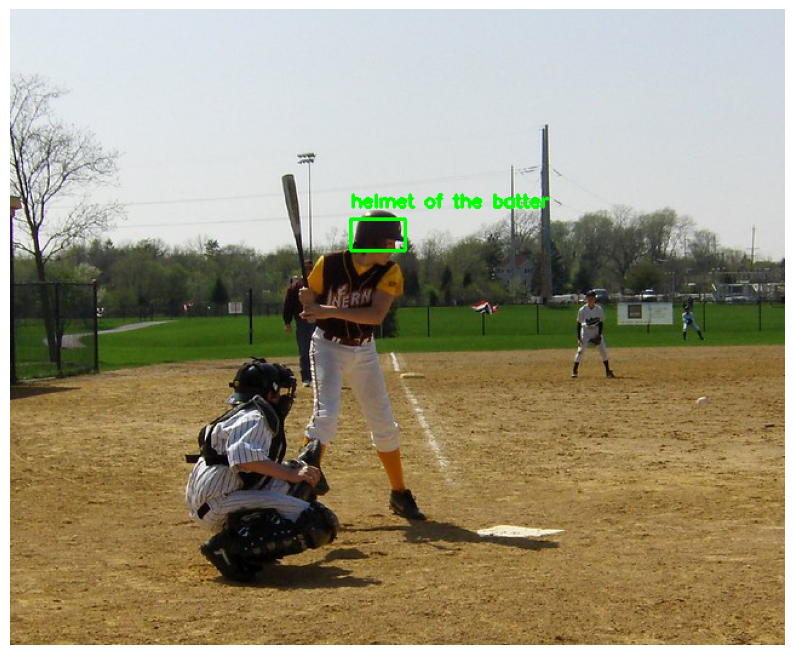

In [95]:
from PIL import Image
import requests
from io import BytesIO
import re
import cv2
from matplotlib import pyplot as plt
import numpy as np

cls = "helmet of the batter"
model.threshold = -1.5

#image_url = 'https://github.com/user-attachments/assets/83258e94-5d61-48ef-a87f-80dd9d895524'
image_url = url = "https://farm3.staticflickr.com/2402/2480652763_e6b62303ee_z.jpg"
response = requests.get(image_url)
image_data = BytesIO(response.content)
pil_image = Image.open(image_data)
pil_image = pil_image.save('image.jpg')
#prompt = f'Give the bounding box coordinates in the normalized format [x1, y1, x2, y2] with x1, y1 corresponding to the top left corner and x2,y2 to the bottom right corner enclosed in square brackets for each {cls} in the image, separated by newlines, and nothing else.'
#prompt = f'Give the bounding box coordinates in the normalized format [x1, y1, x2, y2] with x1, y1 corresponding to the top left corner and x2,y2 to the bottom right corner enclosed in square brackets for each {cls} in the image'
prompt = f'Give the normalized bounding box coordinates in the format [x1, y1, x2, y2] of all instances of {cls} in the image'

content = [
        dict(type='image', image='image.jpg'),
        dict(type='text', text=prompt)
    ]
messages = [
        {
            'role': 'user',
            'content': content
        }
    ]
generation_config = {
        'max_new_tokens': 1024,
        'temperature': 0.0,
        'top_p': 0.0,
        'num_beams': 1,
    }
response = model.chat(
    messages,
    tokenizer,
    image_processor,
    generation_config
)
print(response)

# regex the part of string to extract bounding boxes
pattern = r'(?:[\[\(]\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*[\]\)])|(?:<box>\s*([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s*</box>)'
matches = re.findall(pattern, response)
bounding_boxes = []
for match in matches:
    # Each match is a tuple of 8 elements, only 4 will be filled
    coords = [c for c in match if c != '']
    if len(coords) == 4:
        bounding_boxes.append([float(c) for c in coords])
print(f'Bounding Boxes: {bounding_boxes}')

# Visualize using cv2
# Load the original image for visualization
image_from_url = requests.get(url)
orig_img = Image.open(BytesIO(image_from_url.content)).convert('RGB')
img_cv = np.array(orig_img)  # HWC, RGB
for box in bounding_boxes:
    x1, y1, x2, y2 = box
    # convert these normalized coordinates to pixel values
    h, w, _ = img_cv.shape
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x2 = int(x2 * w)
    y2 = int(y2 * h)
    # Draw the bounding box and label on the image
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_cv, cls, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img_cv)
plt.axis('off')
plt.show() 
